In [1]:
import sys
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from torch_geometric.data import Dataset, download_url, Data
import pandas as pd
import shutil
import torch
from scipy.spatial import distance

from torch_geometric import nn as gnn
import torch.nn.functional as F
from torchvision.transforms.functional import crop
from torch import nn

/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"

In [3]:
class Net(torch.nn.Module):
    def __init__(self, num_nodes, f_len):
        super().__init__()
        self.n = num_nodes
        self.f_len = f_len

        self.graph_enc_layer_1 = gnn.GraphConv(f_len, f_len)
        self.graph_enc_layer_2 = gnn.GraphConv(f_len, int(f_len/4))
        self.graph_enc_layer_3 = gnn.GraphConv(int(f_len/4), int(f_len/16))

        self.relu = nn.ReLU()
        self.conv_enc_pool = nn.MaxPool2d(2,2,0)
        
        self.conv_enc_1 = nn.Conv2d(1, int(self.n * 0.5), 3, 1, 1)
        self.conv_enc_1_1 = nn.Conv2d(int(self.n * 0.5), int(self.n * 0.5), 3, 1, 1)
        self.conv_enc_1_2 = nn.Conv2d(int(self.n * 0.5), int(self.n * 0.5), 3, 1, 1)
        
        self.conv_enc_2 = nn.Conv2d(int(self.n * 1.5), int(self.n*2), 3, 1, 1)
        self.conv_enc_2_1 = nn.Conv2d(int(self.n * 2), int(self.n*2), 3, 1, 1)
        self.conv_enc_2_2 = nn.Conv2d(int(self.n * 2), int(self.n*2), 3, 1, 1)
        
        self.conv_enc_3 = nn.Conv2d(int(self.n * 3), int(self.n*3.5), 3, 1, 1)
        self.conv_enc_3_1 = nn.Conv2d(int(self.n * 3.5), int(self.n*3.5), 3, 1, 1)
        self.conv_enc_3_2 = nn.Conv2d(int(self.n * 3.5), int(self.n*3.5), 3, 1, 1)
        
        self.conv_enc_4 = nn.Conv2d(int(self.n * 4.5), int(self.n*5), 3, 1, 1)

        self.conv_enc_4_1 = nn.Conv2d(int(self.n * 5), int(self.n*5), 3, 1, 1) # - Latent Space

        self.conv_enc_4_2 = nn.Conv2d(int(self.n * 5), int(self.n*5), 3, 1, 1) 

        self.deconv_4 = nn.ConvTranspose2d(int(self.n*5),int(self.n * 4.5), 2,2,0)
        self.conv_dec_4 = nn.Conv2d(int(self.n * 9), int(self.n*4.5), 3, 1, 1)
        self.conv_dec_4_1 = nn.Conv2d(int(self.n * 4.5), int(self.n*4.5), 3, 1, 1)

        self.deconv_3 = nn.ConvTranspose2d(int(self.n * 4.5),int(self.n * 3), 2,2,0)
        self.conv_dec_3 = nn.Conv2d(int(self.n * 6), int(self.n*3), 3, 1, 1)
        self.conv_dec_3_1 = nn.Conv2d(int(self.n * 3), int(self.n*3), 3, 1, 1)

        self.deconv_2 = nn.ConvTranspose2d(int(self.n*3),int(self.n * 1.5), 2,2,0)
        self.conv_dec_2 = nn.Conv2d(int(self.n * 3), int(self.n*1.5), 3, 1, 1)
        self.conv_dec_2_1 = nn.Conv2d(int(self.n * 1.5), int(self.n*1.5), 3, 1, 1)

        self.deconv_1 = nn.ConvTranspose2d(int(self.n*1.5),int(self.n), 2,2,0)
        self.conv_dec_1 = nn.Conv2d(int(self.n), int(self.n*0.5), 3, 1, 1)
        self.conv_dec_1_1 = nn.Conv2d(int(self.n*0.5), int(self.n*0.5), 3, 1, 1)

        self.deconv_out = nn.ConvTranspose2d(int(self.n*0.5),int(3), 2,2,0)
        self.conv_out_1 = nn.Conv2d(3, 3, 1, 1, 0)



    def forward(self, nodes, edge_index, x, y=None):

        g = self.graph_enc_layer_1(nodes, edge_index)
        g = self.relu(g)
        g1 = g.reshape((int(self.n), 64, 64))

        g = self.graph_enc_layer_2(g, edge_index)
        g = self.relu(g)
        g2 = g.reshape((int(self.n), 32, 32))

        g = self.graph_enc_layer_3(g, edge_index)
        g = self.relu(g)
        g3 = g.reshape((int(self.n), 16, 16))

        x = self.conv_enc_1(x)
        x = self.relu(x)
        x = self.conv_enc_1_1(x)
        x = self.relu(x)
        x = self.conv_enc_1_2(x)
        x = self.relu(x)
        
        x1 = torch.cat((x,g1))
        x = self.conv_enc_pool(x1)

        x = self.conv_enc_2(x)
        x = self.relu(x)
        x = self.conv_enc_2_1(x)
        x = self.relu(x)
        x = self.conv_enc_2_2(x)
        x = self.relu(x)
        
        x2 = torch.cat((x,g2))
        x = self.conv_enc_pool(x2)

        x = self.conv_enc_3(x)
        x = self.relu(x)
        x = self.conv_enc_3_1(x)
        x = self.relu(x)
        x = self.conv_enc_3_2(x)
        x = self.relu(x)
        x3 = torch.cat((x,g3))
        x = self.conv_enc_pool(x3)

        x = self.conv_enc_4(x)
        x = self.relu(x)
        x4 = x

        x = self.conv_enc_4_1(x)
        x = self.relu(x)
        x = self.conv_enc_4_2(x)
        x = self.relu(x)

        x = self.deconv_4(x)
        x = torch.cat((x,x3))
        x = self.conv_dec_4(x)
        x = self.relu(x)
        x = self.conv_dec_4_1(x)
        x = self.relu(x)

        x = self.deconv_3(x)
        x = torch.cat((x,x2))
        x = self.conv_dec_3(x)
        x = self.relu(x)
        x = self.conv_dec_3_1(x)
        x = self.relu(x)
        
        x = self.deconv_2(x)
        x = torch.cat((x,x1))
        x = self.conv_dec_2(x)
        x = self.relu(x)
        x = self.conv_dec_2_1(x)
        x = self.relu(x)

        x = self.deconv_1(x)
        x = self.conv_dec_1(x)
        x = self.relu(x)
        x = self.conv_dec_1_1(x)
        x = self.relu(x)
        x = self.deconv_out(x)
        x = self.conv_out_1(x)
        
        
        return x

In [4]:
class One_graph_rest_free(Dataset): #For this ds I have ald done all the required pre prcessing 
    def __init__(self, root, data_dict = None):
        self.data_dict = data_dict
        super().__init__(root, None, None, None)
        
        
    @property
    def raw_file_names(self):
        return "not_implementated.pt"

    @property
    def processed_file_names(self):
        return "not_implemented.pt"
    
    def process(self):
            # Process pre made data dictionary

            x_features = torch.cat((self.data_dict["features"], self.data_dict["centroids"]))
            y = torch.cat((self.data_dict["cluster"], torch.Tensor([i for i in range(self.data_dict["centroids"].shape[0])]))).to(torch.int)
            
            edge_map = []


            i=-1
            for cluster in y[:self.data_dict["features"].shape[0]]:
                i+=1
                edge_map.append([i, cluster+self.data_dict["features"].shape[0]])
            

            i+=1
            for centroid1 in y[i:]:
                for centroid2 in y[i+1:]:
                    edge_map.append([centroid1+self.data_dict["features"].shape[0], centroid2+self.data_dict["features"].shape[0]])
                i+=1

            edge_map = torch.Tensor(edge_map).to(int)
            
            for target in range(self.data_dict["features"].shape[0]):
                sub_ind = [i for i in range(x_features.shape[0]) if i != target]
                x_feat_aux = torch.cat((self.data_dict["features"], self.data_dict["centroids"]))[sub_ind]
                y_aux = {"features":self.data_dict["features"][target], "image":self.data_dict["image"][target]}
                
                
                
                edge_map_aux = [[],[]]
                for x in edge_map:
                    if x[0] != target:
                        
                        edge_map_aux[0].append(x[0])
                        edge_map_aux[1].append(x[1]) 
                        
                edge_map_aux = np.array(edge_map_aux)
                        
               
                
                edge_attrs = []
                for _ in edge_map_aux[0]:
                    edge_attrs.append(1)
                    
                edge_attrs = torch.Tensor(edge_attrs)
                
                g_unique = np.unique(edge_map_aux[0])
                
                g_unique = np.append(g_unique, g_unique[-1]+1)

                for i in range(edge_map_aux[0].shape[0]):
                    edge_map_aux[0][i] = np.where(g_unique==edge_map_aux[0][i])[0][0]
                    edge_map_aux[1][i] = np.where(g_unique==edge_map_aux[1][i])[0][0]
                
                edge_map_aux = torch.Tensor(edge_map_aux).to(int)
            
            
            
                data = Data(x_feat_aux, edge_map_aux, edge_attrs, y_aux)

                torch.save(data, os.path.join(self.processed_dir, f'data_{target}.pt'))

    def len(self):
        return self.data_dict["features"].shape[0]

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

# Data Separation

In [5]:
with open('/home/paulraae/MS_Thesis/tester_code_files/tester_eye_data/test_eye_clusters_extract_202.pk1', 'rb') as handle:
    data = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: '/home/paulraae/MS_Thesis/tester_code_files/tester_eye_data/test_eye_clusters_extract_202.pk1'

In [9]:
data["image"].shape

(202, 224, 224, 3)

In [10]:
unique, counts = np.unique(data["cluster"], return_counts=True)
print(counts)
graph_counts=np.array(np.floor(counts/2), dtype=np.int64)
print(graph_counts)
print(graph_counts.sum())
graph_counts[4] += 1
graph_counts[5] += 1
graph_counts[0] += 1
print(graph_counts)
print(graph_counts.sum())
print(counts - graph_counts)

[31 30  9 31 56 41  4]
[15 15  4 15 28 20  2]
99
[16 15  4 15 29 21  2]
102
[15 15  5 16 27 20  2]


In [11]:
graph_counts

array([16, 15,  4, 15, 29, 21,  2])

In [13]:
np.unique(data["cluster"])

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [15]:
graph = {"features":np.array([np.random.rand(4096)]), "image":np.array([np.random.rand(256,256,3)]) , "cluster":np.array([]), "ind":np.array([])}
free_images = {"train":{"features":None, "y":None, "cluster":None, "ind":None}, "test":{"features":None, "y":None, "cluster":None, "ind":None}}

for i in np.unique(data["cluster"]):
    ind = np.where(data["cluster"] == i)[0]
    np.random.shuffle(ind)
    ind = ind[:graph_counts[i]].astype(np.int64)
    graph["cluster"] = np.concatenate((graph["cluster"], data["cluster"][ind]))
    graph["ind"] = np.concatenate((graph["ind"],ind))
    graph["features"] = np.concatenate((graph["features"],data["features"][ind]))
    graph["image"] = np.concatenate((graph["image"], np.array([cv2.resize(x/255.0, (256,256)) for x in data["image"][ind]])))

free_ind = np.where(np.array([i not in graph["ind"] for i in range(data["features"].shape[0])])==1)[0]
test_ind = np.random.choice(free_ind, 20, replace = False)
train_ind = [i for i in free_ind if i not in test_ind]

graph["cluster"] = torch.Tensor(graph["cluster"]).to(torch.int)
graph["ind"] = torch.Tensor(graph["ind"]).to(torch.int)
graph["features"] = torch.Tensor(graph["features"][1:])
graph["image"] = torch.Tensor(graph["image"][1:])

free_images["train"]["ind"] = torch.Tensor(np.array(train_ind)).to(torch.int)

free_images["train"]["y"] = torch.Tensor(np.array([cv2.resize(x/255.0, (256,256)) for x in data["image"][train_ind]]))

free_images["train"]["features"] = torch.Tensor(data["features"][train_ind])
free_images["train"]["cluster"] = torch.Tensor(data["cluster"][train_ind]).to(torch.int)

free_images["test"]["ind"] = torch.Tensor(np.array(test_ind)).to(torch.int)

free_images["test"]["y"] = torch.Tensor(np.array([cv2.resize(x/255.0, (256,256)) for x in data["image"][test_ind]]))

free_images["test"]["features"] = torch.Tensor(data["features"][test_ind])
free_images["test"]["cluster"] = torch.Tensor(data["cluster"][test_ind]).to(torch.int)


    
    

In [16]:
print(graph["cluster"].shape)
print(graph["ind"].shape)
print(graph["features"].shape)
print(graph["image"].shape)
print()
print(free_images["train"]["ind"].shape)
print(free_images["train"]["y"].shape)
print(free_images["train"]["features"].shape)
print(free_images["train"]["cluster"].shape)
print()
print(free_images["test"]["ind"].shape)
print(free_images["test"]["y"].shape)
print(free_images["test"]["features"].shape)
print(free_images["test"]["cluster"].shape)

torch.Size([102])
torch.Size([102])
torch.Size([102, 4096])
torch.Size([102, 256, 256, 3])

torch.Size([80])
torch.Size([80, 256, 256, 3])
torch.Size([80, 4096])
torch.Size([80])

torch.Size([20])
torch.Size([20, 256, 256, 3])
torch.Size([20, 4096])
torch.Size([20])


In [17]:
graph["centroids"] = torch.Tensor(data["centroids"])
graph["centroids"].shape

torch.Size([7, 4096])

In [19]:
g_unique, g_counts = np.unique(graph["cluster"], return_counts=True)
f_unique, f_counts = np.unique(free_images["train"]["cluster"], return_counts=True)
t_unique, t_counts = np.unique(free_images["test"]["cluster"], return_counts=True)

print(counts)
print(g_unique)
print(g_counts)
print()
print(graph_counts)
print(f_unique)
print(f_counts)
print()
print(t_unique)
print(t_counts)

[31 30  9 31 56 41  4]
[0 1 2 3 4 5 6]
[16 15  4 15 29 21  2]

[16 15  4 15 29 21  2]
[0 1 2 3 4 5 6]
[13 10  3 14 24 14  2]

[0 1 2 3 4 5]
[2 5 2 2 3 6]


In [20]:
total_ds = {"graph":graph, "free_images":free_images}

with open('/home/paulraae/MS_Thesis/tester_code_files/tester_eye_data/one_graph_rest_free//split_pre_graph_data_ds.pk1', 'wb') as handle:
    pickle.dump(total_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
with open('/home/paulraae/MS_Thesis/tester_code_files/tester_eye_data/one_graph_rest_free//split_pre_graph_data_ds.pk1', 'rb') as handle:
    total_ds = pickle.load(handle)

In [75]:
print(graph["features"].shape)
print(graph["centroids"].shape)

torch.Size([102, 4096])
torch.Size([7, 4096])


In [78]:
path = "/home/paulraae/MS_Thesis/tester_code_files/tester_eye_data/one_graph_rest_free/separated"
graph_ds = One_graph_rest_free(path, graph)

Processing...
Done!


In [80]:
graph_ds[0].edge_index[0]

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102,
        103, 103, 103, 103, 104, 104, 104, 105, 105, 106])

In [81]:
graph_ds[0].edge_index[1]

tensor([101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
        102, 102, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 104, 104,
        104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106,
        106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106,
        106, 107, 107, 102, 103, 104, 105, 106, 107, 103, 104, 105, 106, 107,
        104, 105, 106, 107, 105, 106, 107, 106, 107, 107])

In [82]:
total_ds = {"graph":graph_ds, "free_images":free_images}


In [83]:
with open('/home/paulraae/MS_Thesis/tester_code_files/tester_eye_data/one_graph_rest_free//separated_and_free_ds.pk1', 'wb') as handle:
    pickle.dump(total_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
total_ds

{}

# Model Training

In [5]:
with open('/home/paulraae/MS_Thesis/tester_code_files/tester_eye_data/one_graph_rest_free//separated_and_free_ds.pk1', 'rb') as handle:
    dataset = pickle.load(handle)

## Data Check

In [8]:
dataset["graph"][0]

Data(
  x=[108, 4096],
  edge_index=[2, 122],
  edge_attr=[122],
  y={
    features=[4096],
    image=[256, 256, 3],
  }
)

In [9]:
dataset["free_images"]["train"]["features"].shape

torch.Size([80, 4096])

In [10]:
dataset["free_images"]["train"]["y"].shape

torch.Size([80, 256, 256, 3])

In [11]:
dataset["free_images"]["train"]["ind"].shape

torch.Size([80])

## Train

In [29]:
save_path = "/home/paulraae/MS_Thesis/tester_code_files/tester_models/separate_and_free_run_1_unet.pickle"
loss = nn.MSELoss()
epochs = 1000

In [91]:
model = Net(108, 4096).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
best = [0, np.Inf]

In [95]:
#Training loop for model

def train_step(model, optimizer, nodes, edge_index, y_feat, y, loss_func=nn.MSELoss(), run_loss=0,train_count=0):

    #Training loop step as defined for Pytorch models
    optimizer.zero_grad()

    pred = model.forward(nodes, edge_index, y_feat.reshape(1,64,64))
    pred = pred.reshape(256,256,3)
    del nodes
    del y_feat
    del edge_index
    loss = loss_func(pred, y)
    del y
    loss.backward()
    optimizer.step()

    return run_loss+float(loss.detach()), train_count+1



loss_dict = {"train":[], "test":[]}

for epoch in range(epochs):
        run_loss = 0.0
        train_count = 0
        model.train(True)
        self_target = dataset["free_images"]["train"]["ind"].shape[0]
        ind = np.array([i for i in range(self_target)])
        g_ind = np.array([i for i in range(len(dataset["graph"]))])
        np.random.shuffle(g_ind)
        
        
        for graph in g_ind:
          gx = dataset["graph"][graph].x.to(device)
          ge = dataset["graph"][graph].edge_index.to(device)
          
          #x = dataset["graph"][graph].y["features"]
          #y = dataset["graph"][graph].y["image"]
          
          #x=x.to(device)
          #y=y.to(device)
          
          #run_loss, train_count = train_step(model, optimizer, gx, ge, x,  y, loss, run_loss, train_count)
          
          #if epoch>=50:
          np.random.shuffle(ind)
          count = -1
          g_ind2 = np.array([i for i in range(len(dataset["graph"]))])
          for sample in ind[:20]:
            count+=1
          #sample = ind[0]
            x = dataset["free_images"]["train"]["features"][sample]
            y = dataset["free_images"]["train"]["y"][sample]
            x=x.to(device)
            y=y.to(device)
            run_loss, train_count = train_step(model, optimizer, gx, ge, x,  y, loss, run_loss, train_count)
            
            x = dataset["graph"][g_ind2[count]].y["features"]
            y = dataset["graph"][g_ind2[count]].y["image"]
            
            x=x.to(device)
            y=y.to(device)
            
            run_loss, train_count = train_step(model, optimizer, gx, ge, x,  y, loss, run_loss, train_count)
           
          del gx
          del ge
          
        run_test_loss = 0.0
        model.eval()
        with torch.no_grad():
          gx = dataset["graph"][g_ind[0]].x.to(device)
          ge = dataset["graph"][g_ind[0]].edge_index.to(device)
          for i in range(dataset["free_images"]["test"]["ind"].shape[0]):
            x = dataset["free_images"]["test"]["features"][i].reshape(1,64,64)
            y = dataset["free_images"]["test"]["y"][i]
            
            x = x.to(device)
            y = y.to(device)
            
            pred = model.forward(gx, ge, x)
            del x
            
            pred = pred.reshape(256,256,3)
            test_loss = loss(pred, y)
            run_test_loss += float(test_loss.detach())
            del y
          
          del gx
          del ge
      
        run_test_loss = run_test_loss/dataset["free_images"]["test"]["ind"].shape[0]
        loss_dict["test"].append(run_test_loss)
        loss_dict["train"].append(run_loss/train_count)
        
        print(str(epoch), " - Avg train loss:", str(run_loss/train_count), " - Avg test loss:", str(run_test_loss))

        if best[1] > run_test_loss:
          best[1] = run_test_loss
          best[0] = epoch
          torch.save(model.state_dict(), save_path)


0  - Avg train loss: 0.006739166496189165  - Avg test loss: 0.07246601600199938
1  - Avg train loss: 0.002433673977008998  - Avg test loss: 0.07226584823802114


KeyboardInterrupt: 

# Model Test

In [125]:
save_path = "/home/paulraae/MS_Thesis/tester_code_files/tester_models/separate_and_free_run_1_unet.pickle"
model = Net(108, 4096).to(device)
model.load_state_dict(torch.load(save_path, weights_only=True))

<All keys matched successfully>

## Free Train

In [96]:
n=-1

8


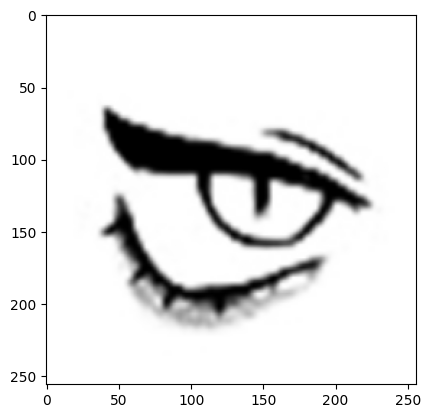

In [141]:
n+=1
print(n)
plt.imshow(dataset["free_images"]["train"]["y"][n])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.24391973..1.1523106].


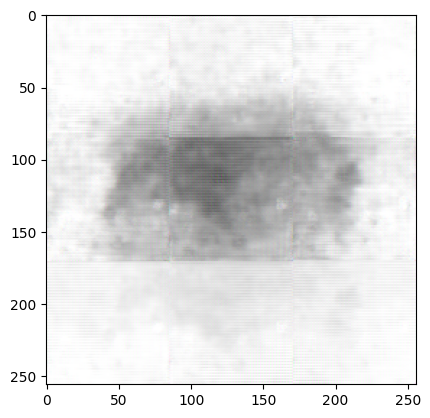

In [142]:
model.eval()
with torch.no_grad():
    test_graph = dataset["graph"][10].x

    test_edges = dataset["graph"][10].edge_index

    test_feats = dataset["free_images"]["train"]["features"][n].reshape(1,64,64)
    test_feats = test_feats.to(device)
    
    test_graph = test_graph.to(device)
    test_edges = test_edges.to(device)

    out = model.forward(test_graph, test_edges, test_feats)

    del test_feats

plt.imshow(out.reshape(256,256,3).cpu().detach().numpy())
plt.show()

## Free Test

In [126]:
n=-1

0


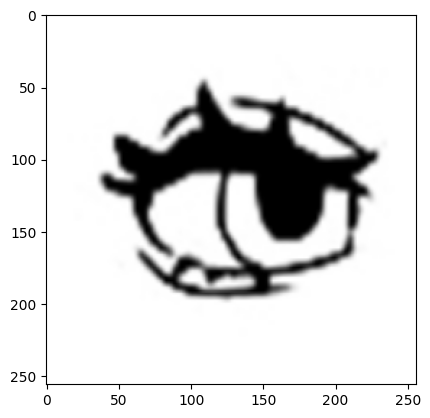

In [128]:
n+=1
print(n)
plt.imshow(dataset["free_images"]["test"]["y"][n])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.26103246..1.1466687].


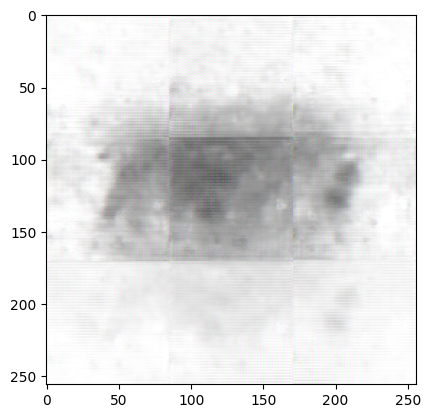

In [129]:
model.eval()
with torch.no_grad():
    test_graph = dataset["graph"][10].x

    test_edges = dataset["graph"][10].edge_index

    test_feats = dataset["free_images"]["test"]["features"][n].reshape(1,64,64)
    test_feats = test_feats.to(device)
    
    test_graph = test_graph.to(device)
    test_edges = test_edges.to(device)

    out = model.forward(test_graph, test_edges, test_feats)

    del test_feats

plt.imshow(out.reshape(256,256,3).cpu().detach().numpy())
plt.show()

## Graph

In [130]:
n=-1

6


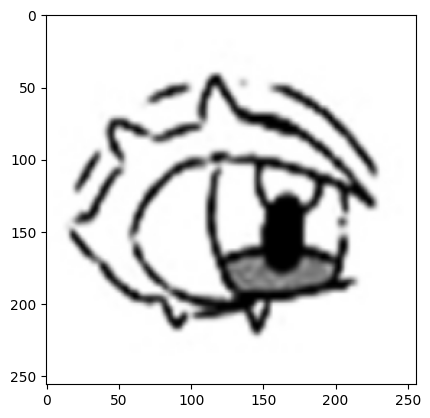

In [137]:
n+=1
print(n)
plt.imshow(dataset["graph"][n].y["image"])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.30828202..1.1577059].


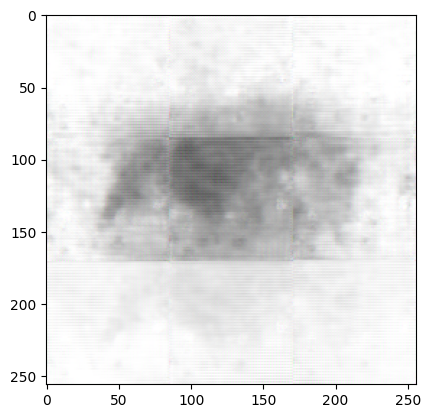

In [138]:
model.eval()
with torch.no_grad():
    test_graph = dataset["graph"][0].x

    test_edges = dataset["graph"][0].edge_index

    test_feats = dataset["graph"][n].y["features"].reshape(1,64,64)
    test_feats = test_feats.to(device)
    
    test_graph = test_graph.to(device)
    test_edges = test_edges.to(device)

    out = model.forward(test_graph, test_edges, test_feats)

    del test_feats

plt.imshow(out.reshape(256,256,3).cpu().detach().numpy())
plt.show()